In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sys
import json
from numpy import linalg as LA

import tensorflow as tf

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)

from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model
from tools_lnd import name_best_ckpt, gen_trials_from_model_dir, get_stim_cats, take_names
from task import generate_trials, rule_name
import tools

In [2]:
figpath = os.path.join(p,'code','overleaf','multitask-nets','v4_figs','paper_figs','fig1','fig1_task_schematic')
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [3]:
def load_X_from_model_dir(model_dir,rule, mode = 'test',noise = False,alpha_mod1 = 0):    
    model = Model(model_dir)
    with tf.Session() as sess:
        model.restore()
        hparams = model.hp
        trial = generate_trials(rule, hparams, mode=mode, batch_size = 20, noise_on=noise, delay_fac =1,alpha_mod1 = alpha_mod1)
        feed_dict = tools.gen_feed_dict(model, trial, hparams)
        h_tf, y_hat = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
            
    return h_tf, y_hat, hparams, trial
    
def plot_epoch_division_nolabel(ax, trial, y_lim, plot_label = False):
    for e in trial.epochs.keys():
        if plot_label ==True:
            e_name ,_ ,_ ,_ = take_names(e,'fdgo')
            ax.text(10*np.max([trial.epochs[e][0],0])+20,1.2,e_name,rotation = 0,fontsize = 14)
        if trial.epochs[e][1]>0:
            ax.plot([10*(trial.epochs[e][1]-1),10*(trial.epochs[e][1]-1)],[-1.8,1.8],'-k',linewidth = 1,alpha = .3)
    ax.set_ylim((y_lim[0]-1,y_lim[1]+1))


In [4]:
task_list = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
              'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
              'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

rule_set_names = ['DelayGo', 'ReactGo', 'MemoryGo', 'DelayAnti', 'ReactAnti', 'MemoryAnti',
              'Decison1', 'Decison2', 'ContextDecison1', 'ContextDecison2', 'MultiDecison',
              'DelayDecison1', 'DelayDecison2', 'ContextDelayDecison1', 'ContextDelayDecison2', 'MultiDelayDecison',
              'DelayMatch2SampleGo', 'DelayMatch2SampleNogo', 'DelayMatch2CategoryGo', 'DelayMatch2CategoryNoGo']

data_folder = os.path.join('data/rnn/multitask/',net,'final')
rnn_type = 'LeakyRNN'
activation = 'softplus'
init = 'diag'
seed = '0'
n_rnn = str(128)
l2w = -6
l2h = -6
l1w = 0
l1h = 0
lr = -7

s = '_'
rule_trains_str = s.join(task_list)
net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str

transfer_m = os.path.join(data_folder,'all',rnn_type,activation,init,
                          str(len(task_list))+'_tasks',str(n_rnn)+'_n_rnn',net_name,seed)

m = os.path.join(p,transfer_m)

In [5]:
rules_dict['all']

['fdgo',
 'reactgo',
 'delaygo',
 'fdanti',
 'reactanti',
 'delayanti',
 'delaydm1',
 'delaydm2',
 'contextdelaydm1',
 'contextdelaydm2',
 'multidelaydm',
 'dmsgo',
 'dmsnogo',
 'dmcgo',
 'dmcnogo']

/usr/local/Caskroom/miniconda/base/envs/tensorflow/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


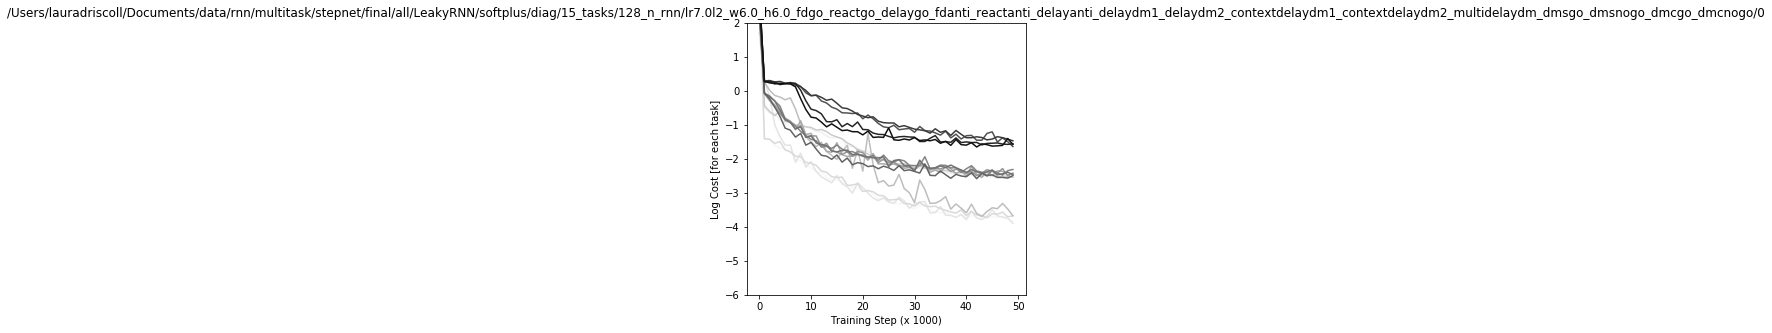

In [6]:
rule_trains = rules_dict['all']
fig = plt.figure(figsize=(5, 5))
cmap=plt.get_cmap('Greys')
fname = os.path.join(m, 'log.json')

with open(fname, 'r') as f:
    log_all = json.load(f)
for ri in range(len(rule_trains)):
    r = rule_trains[ri]
    c = cmap((ri+1)/(len(rule_trains)+1))
    ax = fig.add_subplot(1,1,1)
    x = np.log(log_all['cost_'+r])
    plt.plot(x,'-',c = c)
    ax.set_xlabel('Training Step (x 1000)')
    ax.set_ylabel('Log Cost [for each task]')
    plt.ylim([-6,2])
    
plt.title(m)
plt.show()    

In [7]:
def make_axes_nice(ax,t_len,x_ax_label=False,plot_divisions=True,ylims = [-1,1],label = [],label_y = -1):
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    
    #all xlims are the same
    ax.set_xlim([0,t_len]) 
    
    #set ylims
    ax.spines['left'].set_bounds(ylims[0],ylims[1])
    ax.set_ylim((ylims[0]-.3,ylims[1]+.3))
    ax.set_yticks((ylims[0],ylims[1]))
    
    if x_ax_label==False:
        ax.spines["bottom"].set_visible(False)
        ax.set_xticks([]) 
    else:
        ax.set_xlabel('Time (ms)')
        
    if plot_divisions==True:
        if label=='Fixation':
            plot_label = True
        else:
            plot_label = False
                
        plot_epoch_division_nolabel(ax, trial_f, ylims, plot_label=plot_label)
        
    ax.text(0,label_y,label, fontsize=14, fontweight='bold')
        
        

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel

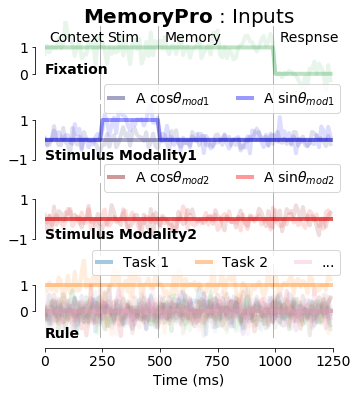

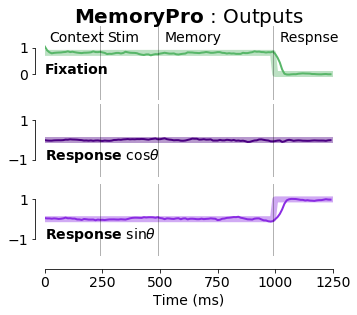

In [11]:
plt.style.use('tableau-colorblind10')

cmap=plt.get_cmap('terrain')
plt.rcParams.update({'font.size': 14})
a = .4
t = 0
lw = 4
# n = True
nr = 4
nc = 1

rule = 'delaygo'
    
h, y_hat, hparams, trial_n = load_X_from_model_dir(m,rule,noise = True)
stim_in = hparams['n_eachring']*hparams['num_ring']

#MAKE INTPUT FIGS
fig = plt.figure(figsize=(4*nc, 1.1*nr))
ax1 = fig.add_axes([0,.75,1,.25])

##colorset for stim
cmap=plt.get_cmap('YlGn')
cmap_set = ['midnightblue','b','darkred','r']
big_stim_in = stim_in+3
c_set = np.arange(0,1,1/big_stim_in)
c_set = np.concatenate((c_set[:int(stim_in/2)],c_set[big_stim_in:int(big_stim_in/2):-1]),axis = 0)
labels1 = [r'A cos$\theta_{mod1}$',r'A sin$\theta_{mod1}$']
labels2 = [r'A cos$\theta_{mod2}$',r'A sin$\theta_{mod2}$']

####subplot1
l = 0    
ax1.plot(range(0,np.shape(trial_n.x)[0]*10,10),trial_n.x[:,t,l], alpha = a/3, linewidth = lw,c = cmap(c_set[l-1]))
h, _, _, trial_f = load_X_from_model_dir(m,rule,noise = False)
ax1.plot(range(0,np.shape(trial_f.x)[0]*10,10),trial_f.x[:,t,l], 'C0', alpha = a, linewidth = lw,c = cmap(c_set[l-1]))
t_len = 10*np.shape(trial_f.x)[0]
make_axes_nice(ax1,t_len,x_ax_label=False,plot_divisions=True,ylims = [0,1],label = 'Fixation',label_y = 0)

####subplot2
ax2 = fig.add_axes([0,.5,1,.25])
for l in range(2):
    plt.plot(range(0,np.shape(trial_n.x)[0]*10,10),trial_n.x[:,t,1+l], alpha = a/3, linewidth = lw,c = cmap_set[l])#,c = cmap(c_set[l])
    plt.plot(range(0,np.shape(trial_f.x)[0]*10,10),trial_f.x[:,t,1+l], alpha = a, linewidth = lw,c = cmap_set[l],label = labels1[l])#,c = cmap(c_set[l])

make_axes_nice(ax2,t_len,x_ax_label=False,plot_divisions=True,label = 'Stimulus Modality1',label_y = -1)
plt.legend(fontsize = 14,loc = 4, bbox_to_anchor=(1.05, .75),handlelength=1,ncol = 2)

####subplot3
ax3 = fig.add_axes([0,.25,1,.25])
for l in range(2):
    plt.plot(range(0,np.shape(trial_n.x)[0]*10,10),trial_n.x[:,t,3+l], alpha = a/3, linewidth = lw,c = cmap_set[l+2])#,c = cmap(c_set[l])
    plt.plot(range(0,np.shape(trial_f.x)[0]*10,10),trial_f.x[:,t,3+l], alpha = a, linewidth = lw,c = cmap_set[l+2], label = labels2[l])#,c = cmap(c_set[l])

make_axes_nice(ax3,t_len,x_ax_label=False,plot_divisions=True,label = 'Stimulus Modality2',label_y = -1)
plt.legend(fontsize = 14,loc = 4, bbox_to_anchor=(1.05, .75),handlelength=1,ncol = 2)

###subplot4
ax4 = fig.add_axes([0,0,1,.25])
cmap=plt.get_cmap('tab20')
task_n = 0
for l in range(15):
    plt.plot(range(0,np.shape(trial_n.x)[0]*10,10),trial_n.x[:,t,stim_in+l+1], alpha = a/3, linewidth = lw,c = cmap(l/20))#,c = cmap(l/20)
    if (l%2)==0:
        if l<4:
            task_n+=1
            print(l)
            plt.plot(range(0,np.shape(trial_f.x)[0]*10,10),trial_f.x[:,t,stim_in+l+1], alpha = a, linewidth = lw,c = cmap(l/20),label = 'Task '+ str(int(task_n)))#,c = cmap(l/20)
    elif l==13:
        plt.plot(range(0,np.shape(trial_f.x)[0]*10,10),trial_f.x[:,t,stim_in+l+1], alpha = a, linewidth = lw,c = cmap(l/20),label = '...')#,c = cmap(l/20)
    else:
        plt.plot(range(0,np.shape(trial_f.x)[0]*10,10),trial_f.x[:,t,stim_in+l+1], alpha = a, linewidth = lw,c = cmap(l/20))#,c = cmap(l/20)


make_axes_nice(ax4,t_len,x_ax_label=True,plot_divisions=True,ylims = [0,1],label = 'Rule',label_y = -1)
plt.legend(fontsize = 14, bbox_to_anchor=(1.05, .7), loc=4,handlelength=1,ncol = 3)

_ ,rule_name ,_ ,_ = take_names('fix1',rule)
ax1.set_title(r"$\bf{"+rule_name+"}$"+' : Inputs',fontsize = 20,y = .9)#, fontweight='bold'

#SAVE INPUT FIGS
figname = 'schematic_inputs_'+rule+'.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname),bbox_inches='tight')

#MAKE OUTPUT FIGS
nr = 4
nc = 1
fig = plt.figure(figsize=(4*nc, 1.1*nr))

##colorset for stim
cmap=plt.get_cmap('YlGn')
cmap_set = ['indigo','blueviolet']
big_stim_in = stim_in+3
c_set = np.arange(0,1,1/big_stim_in)
c_set = np.concatenate((c_set[:int(stim_in/2)],c_set[big_stim_in:int(big_stim_in/2):-1]),axis = 0)
labels = [r'A cos$\theta_{mod1}$',r'A sin$\theta_{mod1}$']

###subplot6
ax = {}
l = 0
ax[l] = fig.add_axes([0,1-(l*.25),1,.25])
ax[l].plot(range(0,np.shape(trial_f.y)[0]*10,10),trial_f.y[:,t,l],'-',alpha = a, linewidth = lw*1.5,c = cmap(c_set[l-1]))
for l in range(1,3):
    ax[l] = fig.add_axes([0,1-(l*.25),1,.25])
    ax[l].plot(range(0,np.shape(trial_f.y)[0]*10,10),trial_f.y[:,t,l],'-',c = cmap_set[l-1],alpha = a, linewidth = lw*1.5)
# plt.legend(('fixation',r'$\cos{\theta}$',r'$\sin{\theta}$'), bbox_to_anchor=(-.16,1.2), 
#            loc="upper left",fontsize = 14,ncol = 3,handlelength=1)

##subplot5
l = 0
ax[l].plot(range(0,np.shape(trial_f.x)[0]*10,10),y_hat[:,t,l],alpha = 1, linewidth = lw/2,c = cmap(c_set[l-1]))
for l in range(1,3):
    ax[l].plot(range(0,np.shape(trial_f.x)[0]*10,10),y_hat[:,t,l],c = cmap_set[l-1],alpha = 1, linewidth = lw/2)
# plt.legend(('fixation',r'$\cos{\theta}$',r'$\sin{\theta}$'), bbox_to_anchor=(-.16,1.2), 
#            loc="upper left",fontsize = 14,ncol = 3,handlelength=1)

label_set = ['Fixation','Response '+ r'$\cos{\theta}$','Response '+r'$\sin{\theta}$']

l = 0
make_axes_nice(ax[l],t_len,x_ax_label=False,plot_divisions=True,ylims = [0,1],label = label_set[l],label_y = 0)

l = 1
make_axes_nice(ax[l],t_len,x_ax_label=False,plot_divisions=True,ylims = [-1,1],label = label_set[l],label_y = -1)

l = 2
make_axes_nice(ax[l],t_len,x_ax_label=True,plot_divisions=True,ylims = [-1,1],label = label_set[l],label_y = -1)

ax[0].set_title(r"$\bf{"+rule_name+"}$"+' : Outputs' ,fontsize = 20,y = .9)#, fontweight='bold'

#SAVE OUTPUT FIGS
figname = 'schematic_output_'+rule+'.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname),bbox_inches='tight')

/usr/local/Caskroom/miniconda/base/envs/tensorflow/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


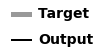

In [9]:
def remove_ax_lines(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

fig = plt.figure(figsize=(.3,.4),tight_layout=True,facecolor='white')
ax = fig.add_axes([0, 0, 1, 1])

[x1,x2] = ax.get_xlim()
x_diff = (x2-x1)/20
[y1,y2] = ax.get_ylim()
y_diff = (y2-y1)/20

x_origin = x1+5*x_diff
y_origin = y2+y_diff
    
plt.plot([x_origin,x_origin+x_diff/2],[y_origin+3.5*y_diff,y_origin+3.5*y_diff],
                 '-k',alpha = a,linewidth = lw*1.5)
plt.text(x_origin+x_diff/1.5,y_origin+3.5*y_diff,'Target',fontsize = 14,verticalalignment='center',fontweight ='bold')

plt.plot([x_origin,x_origin+x_diff/2],[y_origin+2.5*y_diff,y_origin+2.5*y_diff],
         '-k',alpha = 1,linewidth = lw/2)
plt.text(x_origin+x_diff/1.5,y_origin+2.5*y_diff,'Output',fontsize = 14,verticalalignment='center',fontweight ='bold')
        
remove_ax_lines(ax)
ax.set_xticks([])
ax.set_yticks([])

figname = 'schematic_output_legend.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname),bbox_inches='tight')